In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from datetime import datetime as dt
import pickle

In [40]:
df = pd.read_csv('Data/LuxuryAPI.csv')
df[['Date_Pickup','Date_Dropoff']] = df[['Date_Pickup','Date_Dropoff']].apply(pd.to_datetime)
df.head()

,Unnamed: 0,Vehicle_id,Vehicle_Name,Category,Transmission,Base_Price,Price,Date_Pickup,Date_Dropoff
0,227,644881573,Cadillac XTS,Luxury,Automatic,150.09,155.52,2022-11-20,2022-11-21
1,223,636479888,Cadillac XTS,Luxury,Automatic,143.49,148.68,2022-11-20,2022-11-21
2,194,646119413,Cadillac XTS,Luxury,Automatic,137.69,142.67,2022-11-20,2022-11-21
3,208,644901168,Cadillac XTS,Luxury,Automatic,132.64,137.43,2022-11-20,2022-11-21
4,230,636492688,Cadillac XTS,Luxury,Automatic,126.12,130.68,2022-11-20,2022-11-21


In [41]:
start_date = df['Date_Pickup'].iloc[0].strftime('%Y-%m-%d')
end_date = df['Date_Pickup'].iloc[-1].strftime('%Y-%m-%d')
date_range = pd.date_range(start=start_date, end=end_date, freq='D')
count = [((df['Date_Pickup'] <= d) & (d <= df['Date_Dropoff'])).sum() for d in date_range]
start_date, end_date

('2022-11-20', '2023-03-02')

In [42]:
data = {'Date': date_range, 'Count':count}
df_model = pd.DataFrame(data=data)
df_model['Average Price'] = df.groupby(['Date_Pickup'])['Price'].mean().values
df_model.head()

,Date,Count,Average Price
0,2022-11-20,13,125.356154
1,2022-11-21,37,136.171667
2,2022-11-22,39,227.619333
3,2022-11-23,17,383.125000
4,2022-11-24,4,365.250000


In [43]:
df_events = pd.read_csv('Data/Events.csv')
df_events = df_events[['Dates','Location']]

df_score = pd.read_csv('Data/Score.csv')
df_score = df_score[['Date','Score']]

df_events['Dates'] = pd.to_datetime(df_events['Dates'])
df_model = df_model.set_index('Date').join(df_events.set_index('Dates'))

df_score['Date'] = pd.to_datetime(df_score['Date'])
df_model = df_model.join(df_score.set_index('Date'))

df_model['Ordinal Date'] = df_model.index.to_series().apply(lambda x: x.toordinal())
df_model = df_model.join(pd.get_dummies(df_model['Location']))
df_model.drop(columns=['Location'], inplace = True)
df_model.reset_index(drop=True, inplace = True)
df_model.head()

,Count,Average Price,Score,Ordinal Date,Mercedes-Benz Stadium,State Farm Arena
0,13,125.356154,106,738479,1,0
1,37,136.171667,42,738480,0,0
2,39,227.619333,50,738481,0,1
3,17,383.125000,52,738482,0,1
4,4,365.250000,145,738483,0,0


In [44]:
baseline_count = df_model['Count'].mean()
X = df_model.drop(columns = 'Count')
y = df_model['Count']
display(X.head(1))
y.head(1)

,Average Price,Score,Ordinal Date,Mercedes-Benz Stadium,State Farm Arena
0,125.356154,106,738479,1,0


0    13
Name: Count, dtype: int64

In [45]:
model = LinearRegression()
model.fit(X,y)
pickle.dump(model, open('Models/count_model.pkl', 'wb'))

In [46]:
d = dt.strptime('2023-03-03', '%Y-%m-%d').date()
d = d.toordinal()
pred_input = np.array([df_model['Average Price'].mean(),100, d, 0, 0])
pred_input = pred_input.reshape(1,5)
pred_df = pd.DataFrame(data = pred_input, columns = X.columns)
pred_df

,Average Price,Score,Ordinal Date,Mercedes-Benz Stadium,State Farm Arena
0,135.570286,100.0,738582.0,0.0,0.0


In [47]:
preds = model.predict(pred_df)
ans = (preds[0] - baseline_count) / baseline_count * 100
ans = str(round(ans,2))+'%'
display(ans)

'10.18%'

In [48]:
df_model['Date'] = df_model['Ordinal Date'].apply(dt.fromordinal)
df_model.to_csv('Data/ModelData.csv')

Text(0.5, 1.0, 'Luxury Vehicle Pricing')

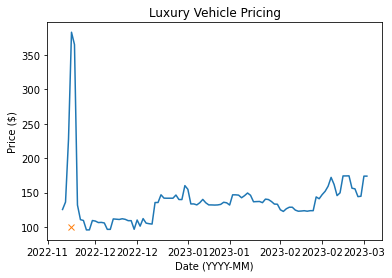

In [71]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
year_month_formatter = mdates.DateFormatter("%Y-%m")
dates = pd.to_datetime(df_model['Date'])
plt.plot(dates,df_model['Average Price'])
single_date = ['2022-11-23']
single_date = pd.to_datetime(single_date)
single_value = [100]
plt.plot(single_date,single_value,marker='x')
plt.gca().xaxis.set_major_formatter(year_month_formatter) 
plt.ylabel('Price ($)')
plt.xlabel('Date (YYYY-MM)')
plt.title('Luxury Vehicle Pricing')
